In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
!pip install onnxruntime
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [92]:
import torchvision
import tensorflow as tf

In [93]:
from torch.utils.data.dataset import Dataset
import pandas as pd
import torch
import ast
from torchvision.io import read_image
import os
import cv2
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms as torchtrans

In [94]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
csv_path = "/content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Progetto/Dataset/testset.csv"
img_path = "/content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Progetto/Dataset/Test"

In [97]:
with tf.device('/cpu:0'):  
  class CoinDataset(Dataset):
    """Euro Coin dataset."""

    def __init__(self, csv_file, root_dir, width, height,transforms=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.coin_frame = pd.read_csv(csv_file, header = None)
        print("Dataset caricato correttamente numero immagini:",len(self.coin_frame))
        self.root_dir = root_dir
        self.transforms = transforms 
        self.height = height
        self.width = width
        self.classes = [_, '10_cent']

    def getClass(self):
      return (self.classes)


    def __len__(self):
        return len(self.coin_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.coin_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0
        sample = {'image': image, 'label' : torch.tensor(1)} 
        
        target = {}
        target['labels'] =  sample['label']
        target["image_id"] = torch.tensor([idx])

        if self.transforms:
              
              sample = self.transforms(image = img_res, labels = sample['label']) 
              
              img_res = sample['image']
              
              
              
        return img_res
    
  dataset = CoinDataset(csv_path, img_path, 150 ,150)

Dataset caricato correttamente numero immagini: 13


In [88]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        a.add_patch(rect)

 
    a.axis('off')
    plt.show()

In [107]:
def plot_img_bbox2(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    classes = dataset.getClass()
    a.imshow(img)
    for box in (target['boxes']):
      x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle((x, y),
                                width, height,
                                linewidth = 2,
                                edgecolor = 'r',
                                facecolor = 'none')

      # Draw the bounding box on top of the image
      a.add_patch(rect)
      score = str(target['scores'][0].item())
      clas = classes[(target['labels'][0].item())]
      legend_text = clas  + '    score: ' + score[:5]
      legend_background = patches.Rectangle((x, y-10),width - 20, 10, facecolor='black', alpha=0.7)
      a.text(x, y-3, legend_text, color = "white")
      a.add_patch(legend_background)
    a.axis('off')
    plt.show()

In [9]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [10]:
def apply_nms(predict, iou_thresh = 0.5):
  boxes = []
  labels = []
  scores = []
  for i in range(len(predict["scores"])):
    if predict["scores"][i].item() > iou_thresh:
      boxes.append(((predict["boxes"][i]).numpy()).tolist())
      labels.append(((predict["labels"][i]).numpy()).tolist())
      scores.append(((predict["scores"][i]).numpy()).tolist())

  predict_p = {'boxes': torch.tensor(boxes), 'labels': torch.tensor(labels), 'scores': torch.tensor(scores)}
  return predict_p

def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

(150, 150, 3)


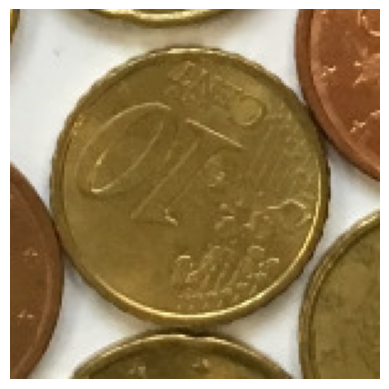

In [13]:
print(image.shape)
plt.imshow(image) 
plt.axis('off')  
plt.show()

In [14]:
img_trs = np.expand_dims(image.transpose(2, 0, 1), axis=0) 
img_cuda = torch.from_numpy(img_trs).cuda()

In [15]:
import torch
import onnx
import onnxruntime
import numpy as np

# Load the ONNX model
onnx_file = "/content/drive/MyDrive/Colab_Notebooks/Machine_Learning/Progetto/CheckPoint/faster_rcnn.onnx"
model = onnx.load(onnx_file)
# Create an ONNX runtime session
session = onnxruntime.InferenceSession(onnx_file)

# Run the model
input_name = session.get_inputs()[0].name
output_names = [output.name for output in session.get_outputs()]
outputs = session.run(output_names, {input_name: img_cuda.cpu().numpy()})

# Process the outputs
boxes, labels, scores = outputs

# Print the results
print('Boxes:', boxes)
print('Labels:', labels)
print('Scores:', scores)

Boxes: [[ 17.900133  15.274761 129.43268  128.57368 ]
 [115.291565   0.       149.84964   68.36718 ]
 [  0.        57.756546  24.218502 148.83826 ]]
Labels: [1 1 1]
Scores: [0.99956053 0.1058119  0.05377314]


In [16]:
boxes_tensor = torch.tensor(boxes)
labels_tensor = torch.tensor(labels)
scores_tensor = torch.tensor(scores)

# Print the Torch tensors
print("Boxes:", boxes_tensor)
print("Labels:", labels_tensor)
print("Scores:", scores_tensor)

predict = {'boxes': boxes_tensor, 'labels': labels_tensor, 'scores': scores_tensor}

# Print the dictionary
print(predict)

Boxes: tensor([[ 17.9001,  15.2748, 129.4327, 128.5737],
        [115.2916,   0.0000, 149.8496,  68.3672],
        [  0.0000,  57.7565,  24.2185, 148.8383]])
Labels: tensor([1, 1, 1])
Scores: tensor([0.9996, 0.1058, 0.0538])
{'boxes': tensor([[ 17.9001,  15.2748, 129.4327, 128.5737],
        [115.2916,   0.0000, 149.8496,  68.3672],
        [  0.0000,  57.7565,  24.2185, 148.8383]]), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.9996, 0.1058, 0.0538])}


In [17]:
img_final= np.transpose(image, (2,0,1))

(3, 150, 150)


In [18]:
img_final = (image*255).astype(np.uint8)

MODEL OUTPUT


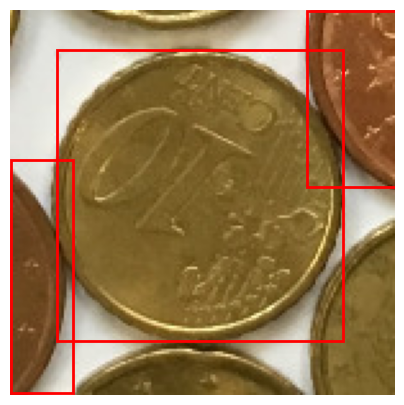

In [89]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img_final), predict)

MODEL OUTPUT


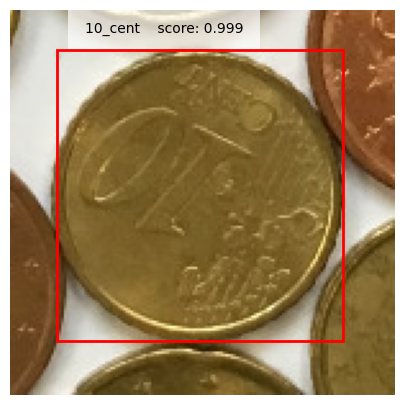

In [108]:
print('MODEL OUTPUT')
nms_prediction = apply_nms(predict, iou_thresh=0.9)
plot_img_bbox2(torch_to_pil(img_final), nms_prediction)